In [29]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

import numpy as np

In [81]:
n = 3
psi = np.arange(0, (1<<n))
np.split(psi, 2)

[array([0, 1, 2, 3]), array([4, 5, 6, 7])]

In [82]:
def theta_amp (amps):
    sub_amps = np.split(amps, 2)
    norm_amps = np.linalg.norm(amps)
    if norm_amps == 0:
        return 0
    return 2*np.arccos(np.linalg.norm(sub_amps[0])/norm_amps)

In [85]:
def amp_to_ang (amps):
    n = int(np.log2(len(amps)))
    angs = [theta_amp(amps)]
    for i in range(1, n):
        sub_amps = np.split(amps, 1<<i)
        for x in sub_amps:
            angs.append(theta_amp(x))
    return angs

In [125]:
def ry_mux (n, theta, state):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='m'+r'$R_Y$'+'\n'+str(state)+'\n'+r'$\theta$'+ '='+str(np.round(theta, 2)))
    qbs = [reg[k+1] for k, x in enumerate(state) if x == '0']
    if len(qbs) != 0:
        circ.x(qbs)
    circ.p(-np.pi/2, reg[0])
    circ.h(reg[0])
    circ.mcrz(theta, reg[1:], reg[0])
    circ.h(reg[0])
    circ.p(np.pi/2, reg[0])
    if len(qbs) != 0:
        circ.x(qbs)
    return circ.to_gate()

In [105]:
def q_amp_prep (n, angs):
    reg = QuantumRegister(n, name='x')
    circ = QuantumCircuit(reg, name='amp_prep')
    circ.ry(angs[0], reg[-1])
    for i in range(1, n):
        for j in range(0, (1<<i)):
            bij = format(j, f'0{i}b')[::-1]
            circ.compose(ry_mux(i+1, angs[(1<<i)+j-1], bij), qubits=reg[-i-1:], inplace=True)
    return circ.to_gate()

1.126243234769772e-15


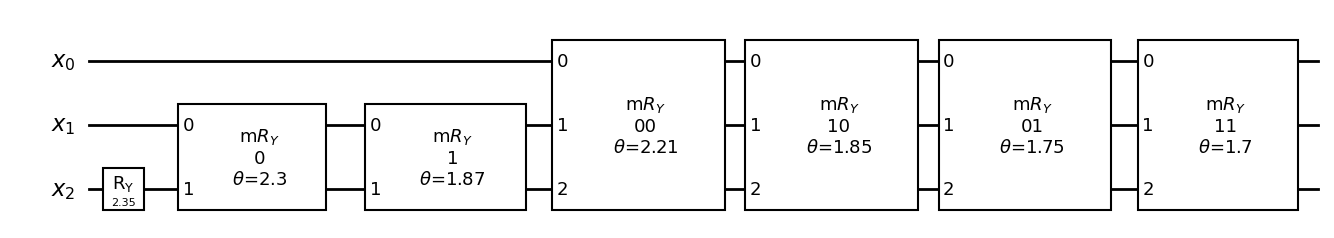

In [126]:
n = 3
psi = np.arange(1, 1+(1<<n))
psi = (1/np.linalg.norm(psi))*psi
qx = QuantumRegister(n, name='x')
qsp = QuantumCircuit(qx)
angs = amp_to_ang(psi)
qsp.compose(q_amp_prep(n, angs), inplace=True)
print(np.linalg.norm(np.array(Statevector(qsp))-psi))
qsp.decompose().draw(output='mpl', style='bw')

In [128]:
psi

array([0.070014  , 0.14002801, 0.21004201, 0.28005602, 0.35007002,
       0.42008403, 0.49009803, 0.56011203])

In [127]:
Statevector(qsp).draw("latex")

<IPython.core.display.Latex object>